# AM 205 - Assignment 4

## By Jonathan Guillotte-Blouin

In [2]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import sys
from scipy.integrate import quad

### Question 2: Totally rocking out in Pierce Hall

#### a)

In [115]:
def get_pierce_map():
    path = "pierce.txt"
    
    return np.array([l.strip().split(" ") for l in open(path, 'r').readlines()],dtype=np.int8)

pierce = get_pierce_map()

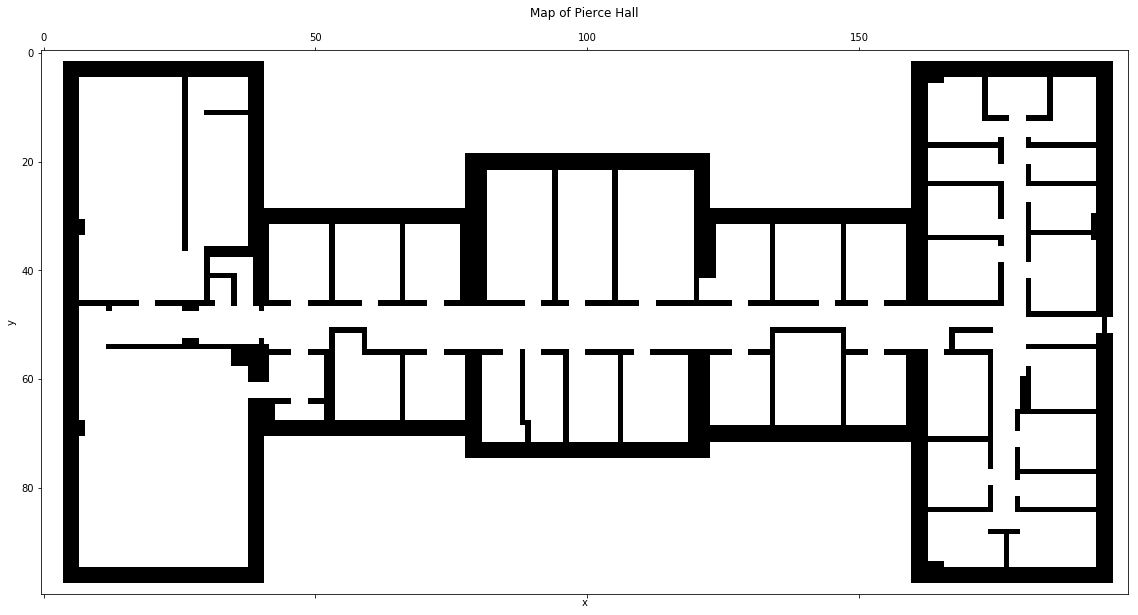

In [116]:
plt.figure(figsize=(20,10))
plt.spy(pierce)
plt.title("Map of Pierce Hall")
plt.xlabel("x")
_ = plt.ylabel("y")

In [125]:
def in_s(j, k):
    return j >= 57 and j <= 60 and k >= 15 and k <= 18

def f(t):
    p0 = 10
    omega = 100 * np.pi
    
    return p0 * np.sin(omega * t)

def get_delta_t():
    return 0.0005 # must be smaller than h / (2c)

def get_n_from_t(t):
    return round(t / get_delta_t())

# compute all P values for cells reachable from S, at time n+1
def p(inside_coords, n, pn=None, pn_min1=None):
    h = 36.6
    c = 3.43e4
    delta_t = get_delta_t()
    pn_plus1 = np.zeros(pierce.shape, dtype=np.float64)

    for j, k in inside_coords:
        if in_s(j, k):
            pn_plus1[j,k] = f(n * delta_t)
            continue
        if n == 0 or n == 1:
            pn_plus1[j,k] = 0
            continue

        pn_j_k = pn[j,k]
        pn_min1_j_k = pn_min1[j,k]
        pn_jplus1_k = pn[j+1, k] if pierce[j+1, k] == 0 else pn_j_k # value changes based on if neighbour is a wall (1) or not
        pn_j_kplus1 = pn[j, k+1] if pierce[j, k+1] == 0 else pn_j_k # value changes based on if neighbour is a wall (1) or not
        pn_jmin1_k = pn[j-1, k] if pierce[j-1, k] == 0 else pn_j_k # value changes based on if neighbour is a wall (1) or not
        pn_j_kmin1 = pn[j, k-1] if pierce[j, k-1] == 0 else pn_j_k # value changes based on if neighbour is a wall (1) or not
        
        pn_plus1[j,k] = delta_t**2 / h**2 * c**2 * (pn_jplus1_k + pn_j_kplus1 - 4*pn_j_k + pn_jmin1_k + pn_j_kmin1) 
        + 2*pn_j_k 
        + pn_min1_j_k

    return pn_plus1

def get_inside_coords(seed):
    visited = set()
    to_visit = []
    
    visiting = seed
    while visiting:
        j, k = visiting
        visited.add(visiting)
        #print(visited)
        if pierce[j-1,k] == 0 and ((j-1,k) not in visited):
            to_visit.append((j-1, k))
        if pierce[j+1,k] == 0 and ((j+1,k) not in visited):
            to_visit.append((j+1, k))
        if pierce[j,k-1] == 0 and ((j,k-1) not in visited):
            to_visit.append((j, k-1))
        if pierce[j,k+1] == 0 and ((j,k+1) not in visited):
            to_visit.append((j, k+1))
        
        if len(to_visit) == 0:
            break
        visiting = to_visit.pop()
        
    return visited
    
# find the cells inside the building reachable from S (seed)
seed = (57, 15)
inside_coords = get_inside_coords(seed)

In [103]:
# NOTE: TAKEN FROM THE FILES
# Returns a scaled value of a function in the range 0 to 1, truncating it if
# necessary
def fscale(v,vmin,vsca):
    vs=(v-vmin)*vsca
    if vs<0: vs=0
    if vs>1: vs=1
    return vs

# Returns a black->red->yellow color scheme (matching Gnuplot's PM3D scheme)
def palette2(v):
    if v>0.5:
        vs=0
    else:
        vs=np.sin(2*np.pi*v)
    return (np.sqrt(v),v*v*v,vs)

# Outputs a 2D image from a field using the palette2 color scheme
# fn: the filename to save to
# p: the 2D field to plot
# wa: the matrix describing walls to overlay
# (vmin,vmax): the field range
# ups: the upsampling factor to use (so each field point is convert into an ups
#      by ups square)
def plot2(duration,p,wa,vmin,vmax,ups):
    
    # Check matrix dimensions are the same
    (m,n)=p.shape
    if (m,n)!=wa.shape:
        print("Matrix dimension mismatch")

    # Set up output array and scaling constant
    o=np.zeros((m*ups,n*ups,3))
    vsca=1.0/(vmax-vmin)

    # Assemble the output array
    for i in range(m):
        iu=i*ups
        for j in range(n):
            ju=j*ups
            if wa[i,j]==1:
                o[iu:iu+ups,ju:ju+ups,0]=1
                o[iu:iu+ups,ju:ju+ups,1]=1
                o[iu:iu+ups,ju:ju+ups,2]=1
            else:
                (re,gr,bl)=palette2(fscale(p[i,j],vmin,vsca))
                o[iu:iu+ups,ju:ju+ups,0]=re
                o[iu:iu+ups,ju:ju+ups,1]=gr
                o[iu:iu+ups,ju:ju+ups,2]=bl

    # Save the image
    print("State after {}s".format(duration))
    return o

State after 0s


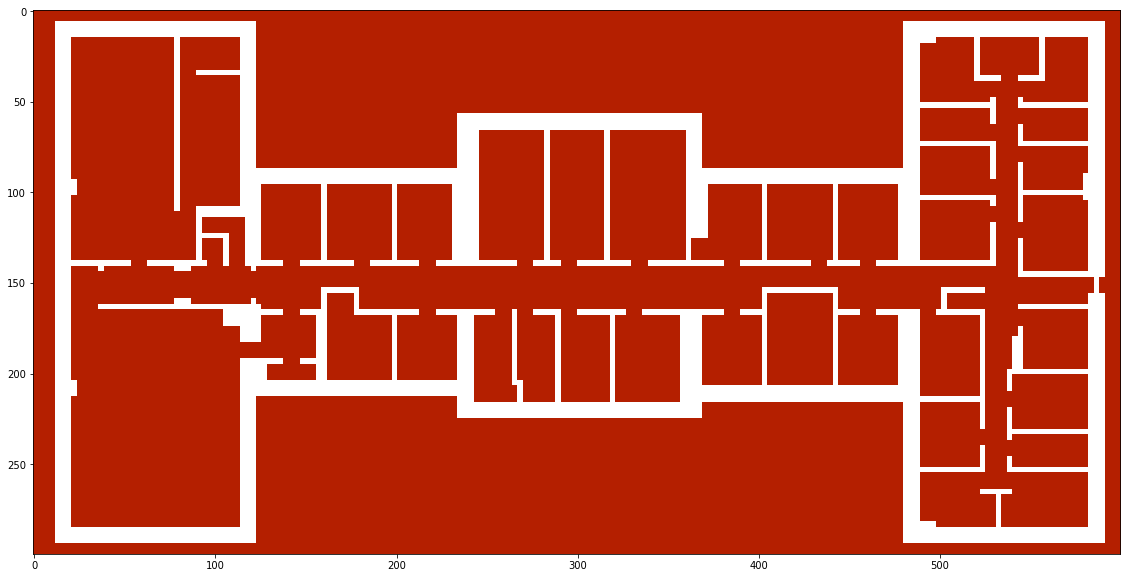

State after 0.0005s


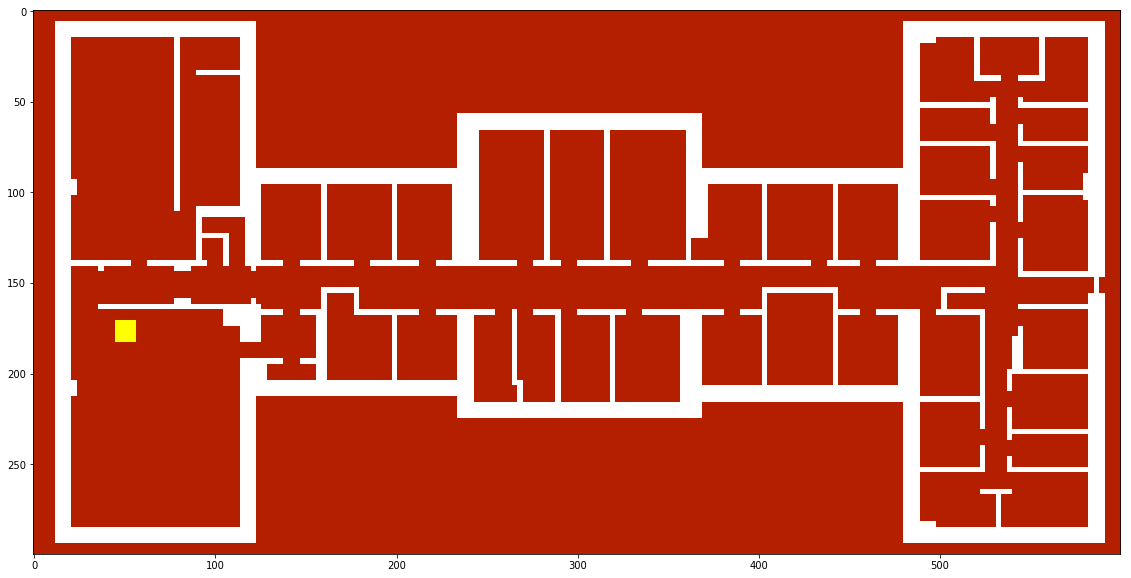

State after 0.015s


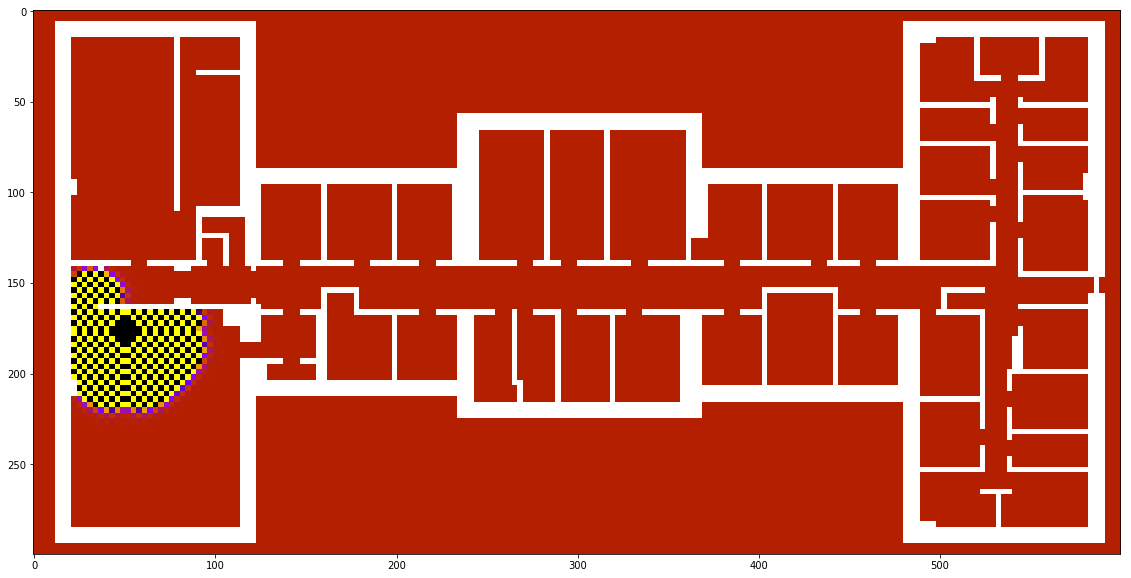

State after 0.105s


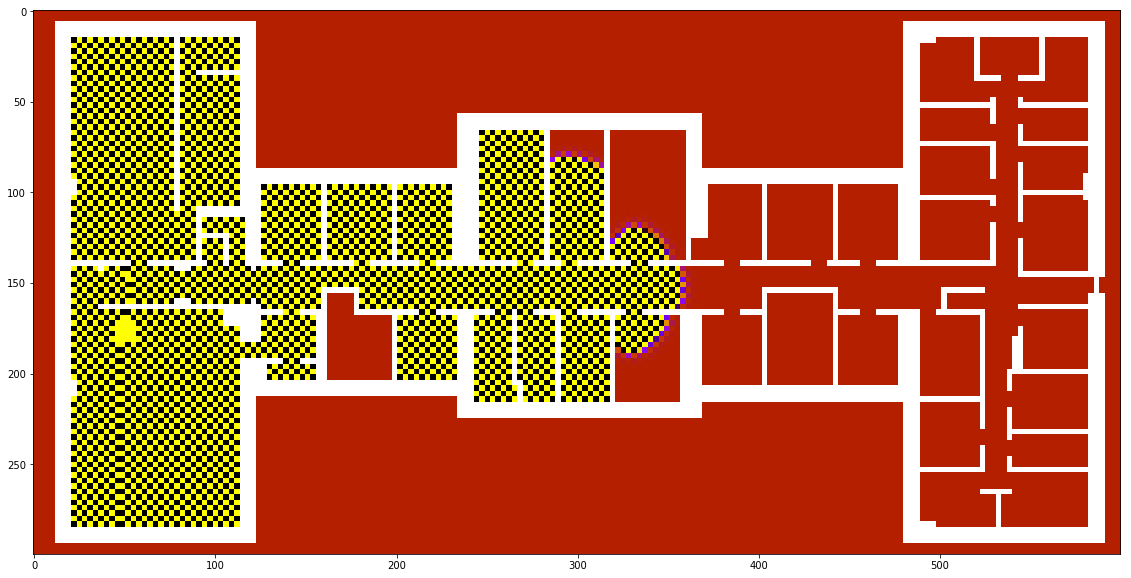

State after 0.505s


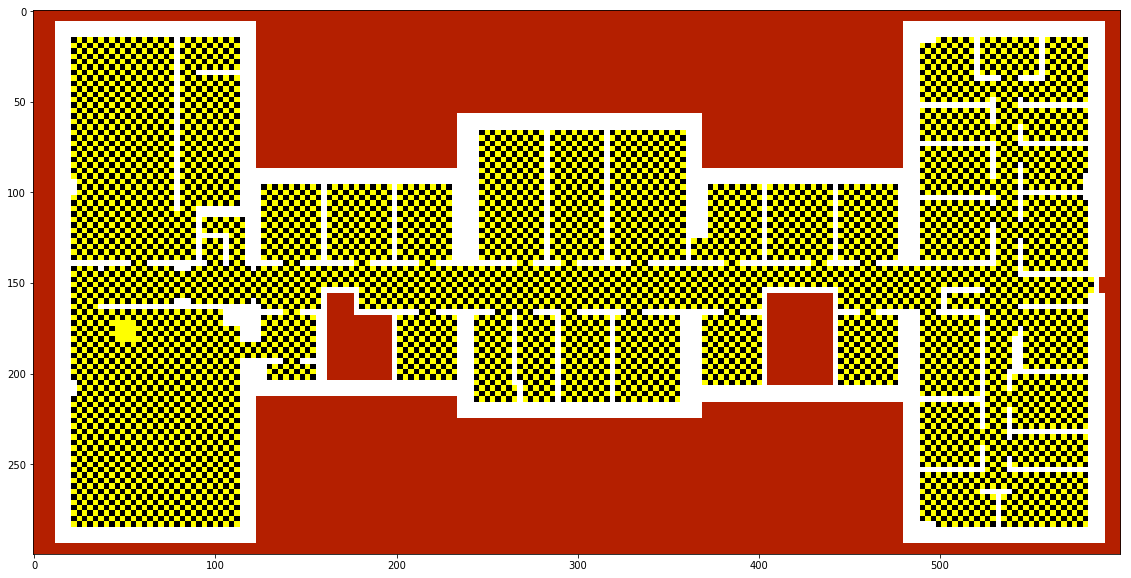

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


State after 1.005s


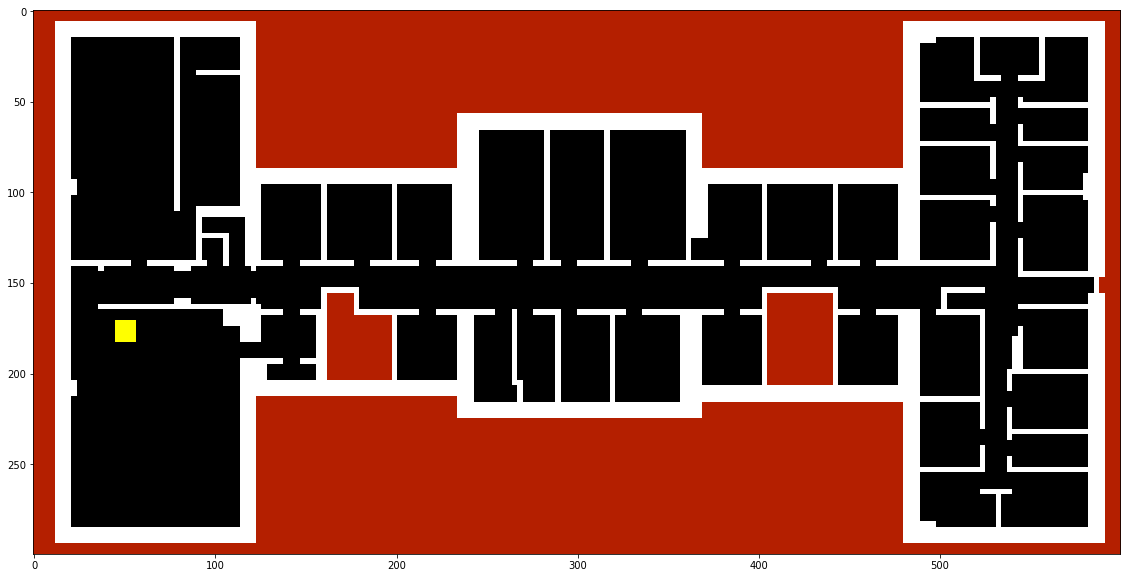

In [126]:
pn_min1, pn = p(inside_coords, 0), p(inside_coords, 1)
plt.figure(figsize=(20,10))
plt.imshow(plot2(0, pn_min1, pierce,-1.1,1.1,3))
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(plot2(get_t_from_n(1), pn, pierce,-1.1,1.1,3))
plt.show()

times_of_interest = [1.005, 0.505, 0.105, 0.015]
ns_of_interest = [get_n_from_t(toi) for toi in times_of_interest]
for n in range(2, max(ns_of_interest)+1):
    pn_plus1 = p(inside_coords, n, pn, pn_min1)
    if n in ns_of_interest:
        plt.figure(figsize=(20,10))
        plt.imshow(plot2(times_of_interest.pop(), pn_plus1, pierce,-1.1,1.1,3))
        plt.show()
    pn_min1 = pn
    pn = pn_plus1